In [ ]:
#mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: ignored

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset

In [ ]:
train_path = "/content/gdrive/MyDrive/Groupwork APS360/baselineset/training"
validation_path = "/content/gdrive/MyDrive/Groupwork APS360/baselineset/validation"
test_path = "/content/gdrive/MyDrive/Groupwork APS360/baselineset/test"

if __name__ = "Train On Local GPU":
  train_path = 'C:\\Users\\guozhending\\Desktop\\baselineset\\training'
  validation_path = 'C:\\Users\\guozhending\\Desktop\\baselineset\\validation'
  test_path = 'C:\\Users\\guozhending\\Desktop\\baselineset\\test'


transform = transforms.Compose([transforms.Resize((50, 50)), transforms.ToTensor()])  
train_data_set = torchvision.datasets.ImageFolder(train_path, transform=transform)
test_data_set = torchvision.datasets.ImageFolder(test_path, transform=transform)
validation_data_set = torchvision.datasets.ImageFolder(validation_path, transform=transform)

#Show the size of each data_set
print("Train image number: ", len(train_data_set))
print("Validation image number: ", len(validation_data_set))
print("Test image number: ", len(test_data_set))

Train image number:  6164
Validation image number:  1508
Test image number:  1470


In [ ]:
classes = ["with", "without", "wrong"]

train_loader = torch.utils.data.DataLoader(train_data_set, batch_size=128, num_workers=1, shuffle= True)
val_loader = torch.utils.data.DataLoader(validation_data_set, batch_size=128, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_set, batch_size=128, num_workers=1, shuffle=True)

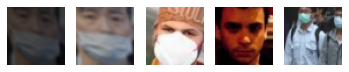

In [ ]:
k = 0
for images, labels in test_loader:
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 4:
        break

In [ ]:
class primary(nn.Module):
    def __init__(self):
        super(primary, self).__init__()
        self.name = "primary"
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = 5, stride = 1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(5, 10, 4)
        self.fc1 = nn.Linear(10*10*10, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*10*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
#get accuracy
#This function returns the performance on a set of data
def get_accuracy(model, loader):
  data = loader

  correct_num = 0
  total_num = 0
  for imgs, lable in data:

    #############################################
      #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      lable = lable.cuda()
      #############################################

    output = model(imgs)

    #Select index with maximum score which will be the prediction result
    pred = output.max(1, keepdim=True)[1]
    correct_num += pred.eq(lable.view_as(pred)).sum().item()
    total_num += imgs.shape[0]
  return correct_num / total_num 

In [ ]:
def train_net(net, train_loader, validation_loader, batch_size=128, learning_rate=0.001, num_epochs=10):

  ############################################################################
  # Train the model on 9 letters
  classes = ["with", "without", "wrong"]

  ############################################################################
  # Fixed PyTorch random seed for reproducible result
  torch.manual_seed(1)

  ############################################################################
  # Define loss function and optimizer
  # In this classification problem, we use crossEntropyLoss
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

  ############################################################################
  #setup arrays to store the loss and error
  iters, losses, train_acc, val_acc = [], [], [], []

  ############################################################################
  #Strat the training process
  print("Start the training process!")

  n = 0 #number of iterations
  for epoch in range(num_epochs):
    
    for imgs, lable in iter(train_loader):
      print(".", end='')

      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        lable = lable.cuda()
      #############################################
      
      # Forward pass, backward pass, and optimize
      output = net(imgs)                        # forward pass
      #print(output.size(), lable.size())
      loss = criterion(output, lable)                 # compute total loss
      loss.backward()                          # backward pass
      optimizer.step()                          # update each parameters
      optimizer.zero_grad()                        # zero the parameter gradients

    print("\r", end='')
    #save current information
    iters.append(n)
    losses.append(float(loss)/batch_size)                                       #compute average loss
    train_acc.append(get_accuracy(model, train_loader))                              #compute train accuracy
    val_acc.append(get_accuracy(model, validation_loader))                             #compute validation accuracy
    print("epoch number = ", n+1, "Training_accuracy = ", train_acc[n], "loss = ", losses[n], "validation_acc = ", val_acc[n])
    n += 1                                                      #update epochs numbers
    model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)                                   #save the check points                            

  ############################################################################
  #plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available! Training on GPU ...
Start the training process!
epoch number =  1 Training_accuracy =  0.3346852693056457 loss =  0.008542639203369617 validation_acc =  0.3275862068965517
epoch number =  2 Training_accuracy =  0.46593121349772876 loss =  0.008575131185352802 validation_acc =  0.47413793103448276
epoch number =  3 Training_accuracy =  0.4928617780661908 loss =  0.008490347303450108 validation_acc =  0.5112732095490716
epoch number =  4 Training_accuracy =  0.512816353017521 loss =  0.008322307839989662 validation_acc =  0.5291777188328912
epoch number =  5 Training_accuracy =  0.5879299156391953 loss =  0.008370084688067436 validation_acc =  0.6021220159151194
epoch number =  6 Training_accuracy =  0.6711550940947437 loss =  0.006917828228324652 validation_acc =  0.6823607427055703
epoch number =  7 Training_accuracy =  0.7177157689811811 loss =  0.005574602168053389 validation_acc =  0.7221485411140584
epoch number =  8 Training_accuracy =  0.7271252433484751 loss =

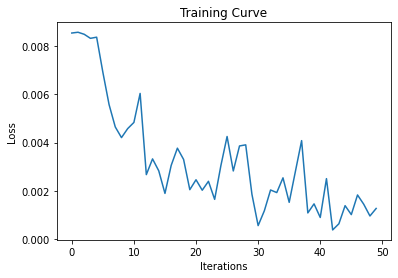

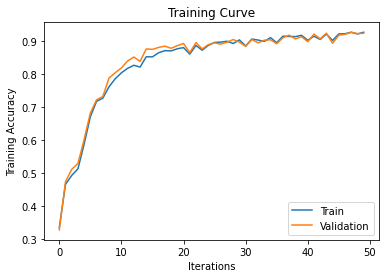

Final Training Accuracy: 0.927319922128488
Final Validation Accuracy: 0.9244031830238727


In [ ]:
use_cuda = True
model = primary()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available! Training on GPU ...')
else:
  print('CUDA is not available. Training on CPU ...')

train_net(model, train_loader, val_loader, batch_size=128, learning_rate=0.001, num_epochs=50)

In [ ]:
best_model = primary().cuda()
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("primary", 128, 0.001, 49)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
test_acc = get_accuracy(best_model, test_loader)
print("The test accuracy of primary model is: ", test_acc)

The test accuracy of primary model is:  0.9027210884353741
